In [63]:
%matplotlib notebook

import matplotlib.pyplot as plt
import numpy as np
import numpy.random
import numpy.linalg
import scipy.io
import scipy.stats
import sklearn.metrics
import random

inNotebook = True # change this to True if you use a notebook
def nextplot():
    if inNotebook:
        plt.figure()  # this creates a new plot
    else:
        plt.clf()     # and this clears the current one

# Load the data

In [39]:
data = scipy.io.loadmat('data/spamData.mat')
X = data['Xtrain']

N = X.shape[0]
D = X.shape[1]

Xtest = data['Xtest']
Ntest = Xtest.shape[0]
y = data['ytrain'].squeeze().astype(int)
ytest = data['ytest'].squeeze().astype(int)

features = np.array([
    "word_freq_make", "word_freq_address", "word_freq_all", "word_freq_3d",
    "word_freq_our", "word_freq_over", "word_freq_remove", "word_freq_internet",
    "word_freq_order", "word_freq_mail", "word_freq_receive", "word_freq_will",
    "word_freq_people", "word_freq_report", "word_freq_addresses", "word_freq_free",
    "word_freq_business", "word_freq_email", "word_freq_you", "word_freq_credit",
    "word_freq_your", "word_freq_font", "word_freq_000", "word_freq_money",
    "word_freq_hp", "word_freq_hpl", "word_freq_george", "word_freq_650",
    "word_freq_lab", "word_freq_labs", "word_freq_telnet", "word_freq_857",
    "word_freq_data", "word_freq_415", "word_freq_85", "word_freq_technology",
    "word_freq_1999", "word_freq_parts", "word_freq_pm", "word_freq_direct",
    "word_freq_cs", "word_freq_meeting", "word_freq_original", "word_freq_project",
    "word_freq_re", "word_freq_edu", "word_freq_table", "word_freq_conference",
    "char_freq_;", "char_freq_(", "char_freq_[", "char_freq_!",
    "char_freq_$", "char_freq_#", "capital_run_length_average", "capital_run_length_longest",
    "capital_run_length_total" ])

# 1. Dataset Statistics

In [40]:
# look some dataset statistics
scipy.stats.describe(X)
print(np.mean(X,axis=1))

[ 20.10449123   4.24650877   4.2464386  ...,   2.33024561   1.55603509
   0.97447368]


<IPython.core.display.Javascript object>


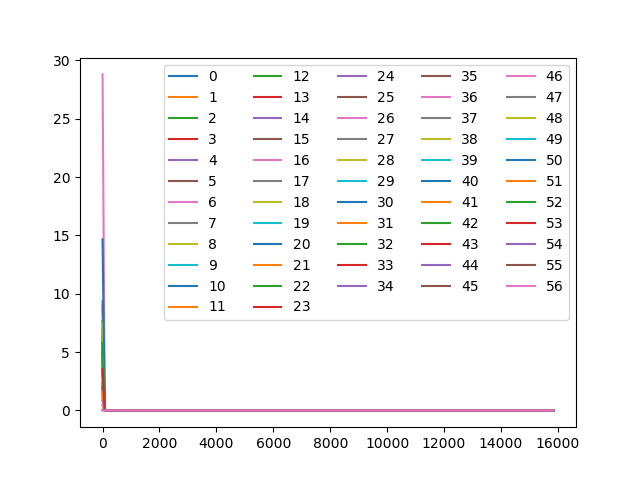

In [41]:
# plot the distribution of all features
nextplot()
densities = [ scipy.stats.gaussian_kde(X[:,j]) for j in range(D) ]

# np.linspace returns arthmetic progression
xs = np.linspace(0,np.max(X),200)

for j in range(D):
    plt.plot(xs, densities[j](xs), label=j)
plt.legend(ncol=5)

<IPython.core.display.Javascript object>


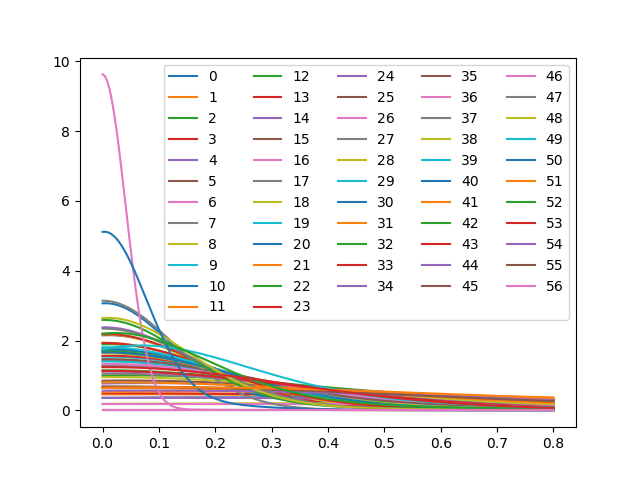

In [73]:
# this plots is not really helpful; go now explore further
# YOUR CODE HERE

nextplot()

densities = list()
for j in range(D):
    kernel =scipy.stats.gaussian_kde(Xz[:,j])
    bw = kernel.covariance_factor()*3.0
    densities.append(scipy.stats.gaussian_kde(X[:,j],bw_method=bw))

# np.linspace returns arthmetic progression
xs = np.linspace(0,0.8,200)

for j in range(D):
    plt.plot(xs, densities[j](xs), label=j)
plt.legend(ncol=5)

In [146]:
# Let's compute z-scores; create two new variables Xz and Xtestz.
def create_new(data):
    mean = np.mean(data, axis=0)
    std = np.std(data, axis=0)
    def z_score(var, mean, std):
        return  (var - mean)/ std 
    re_array = list()
    for i in range(D):
        col = [z_score(X[j,i],mean[i],std[i]) for j in range(len(data))]
        #print(col)
        re_array.append(col)
    return np.transpose(np.asarray(re_array))

Xz = create_new(X)
Xtestz = create_new(Xtest)


In [147]:
# Let's check. Xz and Xtestz refer to the normalized datasets just created. We
# will use them throughout.
a1 = np.mean(Xz, axis=0)                       # should be all 0
a2 = np.var(Xz, axis=0)                        # should be all 1
np.mean(Xtestz, axis=0)                   # what do you get here?
np.var(Xtestz, axis=0)

a3 = np.sum(Xz**3)                             # should be: 1925261.15
print(a1,a2,a3)

[  1.85459768e-17   9.27298839e-18  -5.56379304e-17  -9.27298839e-18
   5.56379304e-17   3.70919536e-17   0.00000000e+00  -7.41839072e-17
   5.56379304e-17   0.00000000e+00  -1.85459768e-17  -2.43415945e-17
  -4.63649420e-17   1.85459768e-17   1.85459768e-17   3.70919536e-17
  -3.70919536e-17  -9.27298839e-17  -1.66913791e-16   9.27298839e-18
   1.85459768e-17   9.27298839e-18  -5.56379304e-17  -1.85459768e-17
  -6.49109188e-17  -3.70919536e-17  -1.85459768e-17   1.85459768e-17
  -2.78189652e-17   4.63649420e-17  -1.85459768e-17   5.56379304e-17
   0.00000000e+00  -1.85459768e-17   3.70919536e-17   1.85459768e-17
  -9.27298839e-18   4.63649420e-18   1.85459768e-17   9.27298839e-18
   2.31824710e-17  -2.78189652e-17  -9.27298839e-18   4.63649420e-18
  -9.27298839e-18  -9.27298839e-18   1.39094826e-17  -2.78189652e-17
  -3.70919536e-17  -6.49109188e-17   4.63649420e-18   3.70919536e-17
  -3.70919536e-17   9.27298839e-18  -9.27298839e-18   9.27298839e-18
  -7.41839072e-17] [ 1.  1.  1.  1

In [45]:
# Explore the normalized data
# YOUR CODE HERE

# 2. Maximum Likelihood Estimation

## Helper functions

In [46]:
def logsumexp(x):
    """Computes log(sum(exp(x)).

    Uses offset trick to reduce risk of numeric over- or underflow. When x is a
    1D ndarray, computes logsumexp of its entries. When x is a 2D ndarray,
    computes logsumexp of each row.

    Keyword arguments:
    x : a 1D or 2D ndarray
    """
    offset = np.max(x, axis=0)
    return offset + np.log(np.sum(np.exp(x-offset), axis=0))

In [47]:
# Define the logistic function. Make sure it operates on both scalars
# and vectors.
def sigma(x):
    # YOUR CODE HERE
    if isinstance(x, np.ndarray):
        re = list()
        for i in x:
            e = 1 / (1 + np.exp(i * -1))
            re.append(e)
        return np.asarray(re)
    else:
        re = 1 / (1 + np.exp(x * -1))
    return re

In [48]:
# this should give:
# [0.5, array([0.26894142, 0.5, 0.73105858])]
[ sigma(0), sigma(np.array([-1,0,1])) ]

[0.5, array([ 0.26894142,  0.5       ,  0.73105858])]

In [49]:
# Define the logarithm of the logistic function. Make sure it operates on both
# scalars and vectors. Perhaps helpful: isinstance(x, np.ndarray).
def logsigma (x):
    # YOUR CODE HERE
    if isinstance(x, np.ndarray):
        re = list()
        for i in x:
            e = np.log(sigma(i))
            re.append(e)
        return np.asarray(re)
    else:
        re = np.log(sigma(x))
    return re

In [50]:
# this should give:
# [-0.69314718055994529, array([-1.31326169, -0.69314718, -0.31326169])]
[ logsigma(0), logsigma(np.array([-1,0,1])) ]

[-0.69314718055994529, array([-1.31326169, -0.69314718, -0.31326169])]

## 2b Log-likelihood and gradient

In [51]:
def l(y, X, w):
    """Log-likelihood of the logistic regression model.

    Parameters
    ----------
    y : ndarray of shape (N,)
        Binary labels (either 0 or 1).
    X : ndarray of shape (N,D)
        Design matrix.
    w : ndarray of shape (D,)
        Weight vector.
    """
    # YOUR CODE HERE
    eta = np.asarray([np.dot(w,i) for i in X])
    ll = np.sum( y * eta - np.log(1 + np.exp(eta)) )
    return ll

In [52]:
# this should give:
# -47066.641667825766
l(y, Xz, np.linspace(-5,5,D))

-47066.641667825774

In [53]:
def dl(y,X,w):
    """Gradient of the log-likelihood of the logistic regression model.

    Parameters
    ----------
    y : ndarray of shape (N,)
        Binary labels (either 0 or 1).
    X : ndarray of shape (N,D)
        Design matrix.
    w : ndarray of shape (D,)
        Weight vector.

    Returns
    -------
    ndarray of shape (D,)
    """
    # YOUR CODE HERE
    eta = np.asarray([np.dot(w,i) for i in X])
    result = list()
    for i in X.T:
        
        # gradient_log_liklihood = ∑ (y - sigma(eta) * x
        gradient_ll = np.sum(np.dot((y - sigma(eta)), i))
        
        a = gradient_ll.tolist()              
        result.append(a)
    return np.asarray(result)
        

In [54]:
# this should give:
# array([  551.33985842,   143.84116318,   841.83373606,   156.87237578,
#          802.61217579,   795.96202907,   920.69045803,   621.96516752,
#          659.18724769,   470.81259805,   771.32406968,   352.40325626,
#          455.66972482,   234.36600888,   562.45454038,   864.83981264,
#          787.19723703,   649.48042176,   902.6478154 ,   544.00539886,
#         1174.78638035,   120.3598967 ,   839.61141672,   633.30453444,
#         -706.66815087,  -630.2039816 ,  -569.3451386 ,  -527.50996698,
#         -359.53701083,  -476.64334832,  -411.60620464,  -375.11950586,
#         -345.37195689,  -376.22044258,  -407.31761977,  -456.23251936,
#         -596.86960184,  -107.97072355,  -394.82170044,  -229.18125598,
#         -288.46356547,  -362.13402385,  -450.87896465,  -277.03932676,
#         -414.99293368,  -452.28771693,  -167.54649092,  -270.9043748 ,
#         -252.20140951,  -357.72497343,  -259.12468742,   418.35938483,
#          604.54173228,    43.10390907,   152.24258478,   378.16731033,
#          416.12032881])
dl(y, Xz, np.linspace(-5,5,D))

array([  551.33985842,   143.84116318,   841.83373606,   156.87237578,
         802.61217579,   795.96202907,   920.69045803,   621.96516752,
         659.18724769,   470.81259805,   771.32406968,   352.40325626,
         455.66972482,   234.36600888,   562.45454038,   864.83981264,
         787.19723703,   649.48042176,   902.6478154 ,   544.00539886,
        1174.78638035,   120.3598967 ,   839.61141672,   633.30453444,
        -706.66815087,  -630.2039816 ,  -569.3451386 ,  -527.50996698,
        -359.53701083,  -476.64334832,  -411.60620464,  -375.11950586,
        -345.37195689,  -376.22044258,  -407.31761977,  -456.23251936,
        -596.86960184,  -107.97072355,  -394.82170044,  -229.18125598,
        -288.46356547,  -362.13402385,  -450.87896465,  -277.03932676,
        -414.99293368,  -452.28771693,  -167.54649092,  -270.9043748 ,
        -252.20140951,  -357.72497343,  -259.12468742,   418.35938483,
         604.54173228,    43.10390907,   152.24258478,   378.16731033,
      

## 2c Gradient descent

In [55]:
# you don't need to modify this function
def optimize(obj_up, theta0, nepochs=50, eps0=0.01):
    """Iteratively minimize a function.

    We use it here to run either gradient descent or stochastic gradient
    descent, using arbitrarly optimization criteria.

    Parameters
    ----------
    obj_up  : a tuple of form (f, update) containing two functions f and update.
              f(theta) computes the value of the objective function.
              update(theta,eps) performs a parameter update with step size eps
              and returns the result.
    theta0  : ndarray of shape (D,)
              Initial parameter vector.
    nepochs : int
              How many epochs (calls to update) to run.
    eps0    : float
              Initial step size.

    Returns
    -------
    A triple consisting of the fitted parameter vector, the values of the
    objective function after every epoch, and the step sizes that were used.
    """

    f, update = obj_up

    # initialize results
    theta = theta0
    
    # contains liklihood value
    values = np.zeros(nepochs+1)
    
    # contains learning rate
    eps = np.zeros(nepochs+1)
    
    values[0] = f(theta0)
    eps[0] = eps0

    # now run the update function nepochs times
        for epoch in range(nepochs):
        print("Epoch {:3d}: f={:10.3f}, eps={:10.9f}".format(epoch, values[epoch], eps[epoch]))
        
        # update newly theta
        theta = update(theta, eps[epoch])

        # we use the bold driver heuristic
        # pre calculate next value of liklihood, if next is smaller than current
        # then means eps set too large, over the peak. So reduce the eps 
        values[epoch+1] = f(theta)
        if (values[epoch] < values[epoch+1]):
            eps[epoch+1] = eps[epoch]/2.
        else:
            eps[epoch+1] = eps[epoch]*1.05

    # all done
    print("Result after {} epochs: f={}".format(nepochs, values[-1]))
    return theta, values, eps

In [157]:
# define the objective and update function for one gradient-descent epoch for
# fitting an MLE estimate of logistic regression with gradient descent (should
# return a tuple of two functions; see optimize)
def gd(y,X):
    # YOUR CODE HERE
    def update(theta, eps):
        return theta + eps * dl(y,X,theta)
    def f(theta):
        # f means calculate the L(theta), the value of liklihood
        return l(y,X,theta)
    return f, update

In [158]:
# this should give
# [47066.641667825766,
#  array([  4.13777838e+01,  -1.56745627e+01,   5.75882538e+01,
#           1.14225143e+01,   5.54249703e+01,   5.99229049e+01,
#           7.11220141e+01,   4.84761728e+01,   5.78067289e+01,
#           4.54794720e+01,   7.14638492e+01,   1.51369386e+01,
#           3.36375739e+01,   2.15061217e+01,   5.78014255e+01,
#           6.72743066e+01,   7.00829312e+01,   5.29328088e+01,
#           6.16042473e+01,   5.50018510e+01,   8.94624817e+01,
#           2.74784480e+01,   8.51763599e+01,   5.60363965e+01,
#          -2.55865589e+01,  -1.53788213e+01,  -4.67015412e+01,
#          -2.50356570e+00,  -3.85357592e+00,  -2.21819155e+00,
#           3.32098671e+00,   3.86933390e+00,  -2.00309898e+01,
#           3.84684492e+00,  -2.19847927e-01,  -1.29775457e+00,
#          -1.28374302e+01,  -2.78303173e+00,  -5.61671182e+00,
#           1.73657121e+01,  -6.81197570e+00,  -1.20249002e+01,
#           2.65789491e+00,  -1.39557852e+01,  -2.01135653e+01,
#          -2.72134051e+01,  -9.45952961e-01,  -1.02239111e+01,
#           1.52794293e-04,  -5.18938123e-01,  -3.19717561e+00,
#           4.62953437e+01,   7.87893022e+01,   1.88618651e+01,
#           2.85195027e+01,   5.04698358e+01,   6.41240689e+01])
f, update = gd(y, Xz)
[ f(np.linspace(-5,5,D)),
  update(np.linspace(-5,-5,D), .1) ]

[-47066.641667825774,
 array([  4.13777838e+01,  -1.56745627e+01,   5.75882538e+01,
          1.14225143e+01,   5.54249703e+01,   5.99229049e+01,
          7.11220141e+01,   4.84761728e+01,   5.78067289e+01,
          4.54794720e+01,   7.14638492e+01,   1.51369386e+01,
          3.36375739e+01,   2.15061217e+01,   5.78014255e+01,
          6.72743066e+01,   7.00829312e+01,   5.29328088e+01,
          6.16042473e+01,   5.50018510e+01,   8.94624817e+01,
          2.74784480e+01,   8.51763599e+01,   5.60363965e+01,
         -2.55865589e+01,  -1.53788213e+01,  -4.67015412e+01,
         -2.50356570e+00,  -3.85357592e+00,  -2.21819155e+00,
          3.32098671e+00,   3.86933390e+00,  -2.00309898e+01,
          3.84684492e+00,  -2.19847927e-01,  -1.29775457e+00,
         -1.28374302e+01,  -2.78303173e+00,  -5.61671182e+00,
          1.73657121e+01,  -6.81197570e+00,  -1.20249002e+01,
          2.65789491e+00,  -1.39557852e+01,  -2.01135653e+01,
         -2.72134051e+01,  -9.45952961e-01,  -1.

In [159]:
# you can run gradient descent!
numpy.random.seed(0)
w0 = np.random.normal(size=D)
wz_gd, vz_gd, ez_gd = optimize(gd(y,Xz), w0, nepochs=500)

Epoch   0: f= -6636.208, eps=0.010000000
Epoch   1: f= -4216.957, eps=0.005000000
Epoch   2: f= -3333.392, eps=0.002500000
Epoch   3: f= -3024.939, eps=0.001250000
Epoch   4: f= -2891.122, eps=0.000625000
Epoch   5: f= -2828.670, eps=0.000312500
Epoch   6: f= -2798.489, eps=0.000156250
Epoch   7: f= -2783.650, eps=0.000078125
Epoch   8: f= -2776.293, eps=0.000039063
Epoch   9: f= -2772.630, eps=0.000019531
Epoch  10: f= -2770.802, eps=0.000009766
Epoch  11: f= -2769.889, eps=0.000004883
Epoch  12: f= -2769.433, eps=0.000002441
Epoch  13: f= -2769.205, eps=0.000001221
Epoch  14: f= -2769.091, eps=0.000000610
Epoch  15: f= -2769.034, eps=0.000000305
Epoch  16: f= -2769.005, eps=0.000000153
Epoch  17: f= -2768.991, eps=0.000000076
Epoch  18: f= -2768.984, eps=0.000000038
Epoch  19: f= -2768.980, eps=0.000000019
Epoch  20: f= -2768.978, eps=0.000000010
Epoch  21: f= -2768.977, eps=0.000000005
Epoch  22: f= -2768.977, eps=0.000000002
Epoch  23: f= -2768.977, eps=0.000000001
Epoch  24: f= -2

Epoch 200: f= -2768.977, eps=0.000000000
Epoch 201: f= -2768.977, eps=0.000000000
Epoch 202: f= -2768.977, eps=0.000000000
Epoch 203: f= -2768.977, eps=0.000000000
Epoch 204: f= -2768.977, eps=0.000000000
Epoch 205: f= -2768.977, eps=0.000000000
Epoch 206: f= -2768.977, eps=0.000000000
Epoch 207: f= -2768.977, eps=0.000000000
Epoch 208: f= -2768.977, eps=0.000000000
Epoch 209: f= -2768.977, eps=0.000000000
Epoch 210: f= -2768.977, eps=0.000000000
Epoch 211: f= -2768.977, eps=0.000000000
Epoch 212: f= -2768.977, eps=0.000000000
Epoch 213: f= -2768.977, eps=0.000000000
Epoch 214: f= -2768.977, eps=0.000000000
Epoch 215: f= -2768.977, eps=0.000000000
Epoch 216: f= -2768.977, eps=0.000000000
Epoch 217: f= -2768.977, eps=0.000000000
Epoch 218: f= -2768.977, eps=0.000000000
Epoch 219: f= -2768.977, eps=0.000000000
Epoch 220: f= -2768.977, eps=0.000000000
Epoch 221: f= -2768.977, eps=0.000000000
Epoch 222: f= -2768.977, eps=0.000000000
Epoch 223: f= -2768.977, eps=0.000000000
Epoch 224: f= -2

Epoch 400: f= -2768.977, eps=0.000000000
Epoch 401: f= -2768.977, eps=0.000000000
Epoch 402: f= -2768.977, eps=0.000000000
Epoch 403: f= -2768.977, eps=0.000000000
Epoch 404: f= -2768.977, eps=0.000000000
Epoch 405: f= -2768.977, eps=0.000000000
Epoch 406: f= -2768.977, eps=0.000000000
Epoch 407: f= -2768.977, eps=0.000000000
Epoch 408: f= -2768.977, eps=0.000000000
Epoch 409: f= -2768.977, eps=0.000000000
Epoch 410: f= -2768.977, eps=0.000000000
Epoch 411: f= -2768.977, eps=0.000000000
Epoch 412: f= -2768.977, eps=0.000000000
Epoch 413: f= -2768.977, eps=0.000000000
Epoch 414: f= -2768.977, eps=0.000000000
Epoch 415: f= -2768.977, eps=0.000000000
Epoch 416: f= -2768.977, eps=0.000000000
Epoch 417: f= -2768.977, eps=0.000000000
Epoch 418: f= -2768.977, eps=0.000000000
Epoch 419: f= -2768.977, eps=0.000000000
Epoch 420: f= -2768.977, eps=0.000000000
Epoch 421: f= -2768.977, eps=0.000000000
Epoch 422: f= -2768.977, eps=0.000000000
Epoch 423: f= -2768.977, eps=0.000000000
Epoch 424: f= -2

In [160]:
# look at how gradient descent made progess
# YOUR CODE HERE
print(wz_gd, vz_gd, ez_gd)


[ 0.4375642  -1.34823739  0.47001366  2.45893148  1.17804762  2.40731431
  3.94263946  2.97178881  2.71378372  0.56310202  1.83895634 -1.89253477
 -0.07234727  0.51102879  1.69922813  3.76559506  2.89576131  1.73353169
  1.69210858  3.28361235  3.45730807  1.90036716  3.43287126  2.98761086
 -3.08385431 -3.97114207 -0.63146958 -2.25037466 -1.19233346 -2.13410327
 -2.12370344 -0.97591985 -1.09222422 -3.34988333 -1.9366286  -2.14293564
 -1.36288684 -0.34322901 -1.41073825 -0.96925585 -1.08407455 -3.129069
 -1.43559238 -0.99333758 -1.33773537 -1.14934899 -0.80274319 -1.61631879
 -1.01503984 -0.25142044 -0.2976464   2.33197031  4.32853795  0.20444799
  0.74489091  2.33430932  2.55840878] [-6636.20835095 -4216.95673422 -3333.39166768 -3024.9389184  -2891.12166634
 -2828.6695257  -2798.48850652 -2783.65040087 -2776.29315656 -2772.62980871
 -2770.80193005 -2769.88893656 -2769.4326759  -2769.20460455 -2769.09058361
 -2769.03357682 -2769.00507435 -2768.99082334 -2768.98369789 -2768.98013519
 -2

In [106]:
print(w0)

[ 1.76405235  0.40015721  0.97873798  2.2408932   1.86755799 -0.97727788
  0.95008842 -0.15135721 -0.10321885  0.4105985   0.14404357  1.45427351
  0.76103773  0.12167502  0.44386323  0.33367433  1.49407907 -0.20515826
  0.3130677  -0.85409574 -2.55298982  0.6536186   0.8644362  -0.74216502
  2.26975462 -1.45436567  0.04575852 -0.18718385  1.53277921  1.46935877
  0.15494743  0.37816252 -0.88778575 -1.98079647 -0.34791215  0.15634897
  1.23029068  1.20237985 -0.38732682 -0.30230275 -1.04855297 -1.42001794
 -1.70627019  1.9507754  -0.50965218 -0.4380743  -1.25279536  0.77749036
 -1.61389785 -0.21274028 -0.89546656  0.3869025  -0.51080514 -1.18063218
 -0.02818223  0.42833187  0.06651722]


## 2d Stochastic gradient descent

In [111]:
def sgdepoch(y,X,w,eps):
    """Run one SGD epoch and return the updated weight vector. """
    # Run N stochastic gradient steps (without replacement). Do not rescale each
    # step by factor N (i.e., proceed differntly than in the lecture slides).
    # YOUR CODE HERE

    #
    i = random.randint(0,len(y)-1)
    eta = np.dot(X[i],w)
    
    # gradient_log_liklihood = ∑ (y - sigma(eta) * x
    gradient_ll = np.dot((y[i] - sigma(eta)), X[i])
    
    theta = w + eps * gradient_ll
    return theta

In [115]:
# when you run this multiple times, with 50% probability you should get the
# following result (there is one other result which is very close):
# array([ -3.43689655e+02,  -1.71161311e+02,  -5.71093536e+02,
#         -5.16478220e+01,   4.66294348e+02,  -3.71589878e+02,
#          5.21493183e+02,   1.25699230e+03,   8.33804130e+02,
#          5.63185399e+02,   1.32761302e+03,  -2.64104011e+02,
#          7.10693307e+02,  -1.75497331e+02,  -1.94174427e+02,
#          1.11641507e+02,  -3.30817509e+02,  -3.46754913e+02,
#          8.48722111e+02,  -1.89136304e+02,  -4.25693844e+02,
#         -1.23084189e+02,  -2.95894797e+02,  -2.35789333e+02,
#         -3.38695243e+02,  -3.05642830e+02,  -2.28975383e+02,
#         -2.38075137e+02,  -1.66702530e+02,  -2.27341599e+02,
#         -1.77575620e+02,  -1.49093855e+02,  -1.70028859e+02,
#         -1.50243833e+02,  -1.82986008e+02,  -2.41143708e+02,
#         -3.31047159e+02,  -5.79991185e+01,  -1.98477863e+02,
#         -1.91264948e+02,  -1.17371919e+02,  -1.66953779e+02,
#         -2.01472565e+02,  -1.23330949e+02,  -3.00857740e+02,
#         -1.95853348e+02,  -7.44868073e+01,  -1.11172370e+02,
#         -1.57618226e+02,  -1.25729512e+00,  -1.45536466e+02,
#         -1.43362438e+02,  -3.00429708e+02,  -9.84391082e+01,
#         -4.54152047e+01,  -5.26492232e+01,  -1.45175427e+02])
sgdepoch(y[1:3],Xz[1:3,:],np.linspace(-5,5,D),1000)

array([ -3.43689655e+02,  -1.71161311e+02,  -5.71093536e+02,
        -5.16478220e+01,   4.66294348e+02,  -3.71589878e+02,
         5.21493183e+02,   1.25699230e+03,   8.33804130e+02,
         5.63185399e+02,   1.32761302e+03,  -2.64104011e+02,
         7.10693307e+02,  -1.75497331e+02,  -1.94174427e+02,
         1.11641507e+02,  -3.30817509e+02,  -3.46754913e+02,
         8.48722111e+02,  -1.89136304e+02,  -4.25693844e+02,
        -1.23084189e+02,  -2.95894797e+02,  -2.35789333e+02,
        -3.38695243e+02,  -3.05642830e+02,  -2.28975383e+02,
        -2.38075137e+02,  -1.66702530e+02,  -2.27341599e+02,
        -1.77575620e+02,  -1.49093855e+02,  -1.70028859e+02,
        -1.50243833e+02,  -1.82986008e+02,  -2.41143708e+02,
        -3.31047159e+02,  -5.79991185e+01,  -1.98477863e+02,
        -1.91264948e+02,  -1.17371919e+02,  -1.66953779e+02,
        -2.01472565e+02,  -1.23330949e+02,  -3.00857740e+02,
        -1.95853348e+02,  -7.44868073e+01,  -1.11172370e+02,
        -1.57618226e+02,

In [102]:
# define the objective and update function for one gradient-descent epoch for
# fitting an MLE estimate of logistic regression with stochastic gradient descent
# (should return a tuple of two functions; see optimize)
def sgd(y,X):
    # YOUR CODE HERE
    def update(theta, eps):
        return sgdepoch(y,X,theta,eps)
    def f(theta):
        # f means calculate the L(theta), the value of liklihood
        return l(y,X,theta) * -1
    return f, update

In [103]:
# with 50% probability, you should get:
# [40.864973045695081,
#  array([ -3.43689655e+02,  -1.71161311e+02,  -5.71093536e+02,
#          -5.16478220e+01,   4.66294348e+02,  -3.71589878e+02,
#           5.21493183e+02,   1.25699230e+03,   8.33804130e+02,
#           5.63185399e+02,   1.32761302e+03,  -2.64104011e+02,
#           7.10693307e+02,  -1.75497331e+02,  -1.94174427e+02,
#           1.11641507e+02,  -3.30817509e+02,  -3.46754913e+02,
#           8.48722111e+02,  -1.89136304e+02,  -4.25693844e+02,
#          -1.23084189e+02,  -2.95894797e+02,  -2.35789333e+02,
#          -3.38695243e+02,  -3.05642830e+02,  -2.28975383e+02,
#          -2.38075137e+02,  -1.66702530e+02,  -2.27341599e+02,
#          -1.77575620e+02,  -1.49093855e+02,  -1.70028859e+02,
#          -1.50243833e+02,  -1.82986008e+02,  -2.41143708e+02,
#          -3.31047159e+02,  -5.79991185e+01,  -1.98477863e+02,
#          -1.91264948e+02,  -1.17371919e+02,  -1.66953779e+02,
#          -2.01472565e+02,  -1.23330949e+02,  -3.00857740e+02,
#          -1.95853348e+02,  -7.44868073e+01,  -1.11172370e+02,
#          -1.57618226e+02,  -1.25729512e+00,  -1.45536466e+02,
#          -1.43362438e+02,  -3.00429708e+02,  -9.84391082e+01,
#          -4.54152047e+01,  -5.26492232e+01,  -1.45175427e+02])]
f, update = sgd(y[1:3], Xz[1:3,:])
[ f(np.linspace(-5,5,D)),
  update(np.linspace(-5,5,D), 1000) ]

[40.864973045695081,
 array([ -3.43689655e+02,  -1.71161311e+02,  -5.71093536e+02,
         -5.16478220e+01,   4.66294348e+02,  -3.71589878e+02,
          5.21493183e+02,   1.25699230e+03,   8.33804130e+02,
          5.63185399e+02,   1.32761302e+03,  -2.64104011e+02,
          7.10693307e+02,  -1.75497331e+02,  -1.94174427e+02,
          1.11641507e+02,  -3.30817509e+02,  -3.46754913e+02,
          8.48722111e+02,  -1.89136304e+02,  -4.25693844e+02,
         -1.23084189e+02,  -2.95894797e+02,  -2.35789333e+02,
         -3.38695243e+02,  -3.05642830e+02,  -2.28975383e+02,
         -2.38075137e+02,  -1.66702530e+02,  -2.27341599e+02,
         -1.77575620e+02,  -1.49093855e+02,  -1.70028859e+02,
         -1.50243833e+02,  -1.82986008e+02,  -2.41143708e+02,
         -3.31047159e+02,  -5.79991185e+01,  -1.98477863e+02,
         -1.91264948e+02,  -1.17371919e+02,  -1.66953779e+02,
         -2.01472565e+02,  -1.23330949e+02,  -3.00857740e+02,
         -1.95853348e+02,  -7.44868073e+01,  -1.1

In [161]:
# you can run stochastic gradient descent!
wz_sgd, vz_sgd, ez_sgd = optimize(sgd(y,Xz), w0, nepochs=500)

Epoch   0: f=  6636.208, eps=0.010000000
Epoch   1: f=  6640.764, eps=0.005000000
Epoch   2: f=  6570.512, eps=0.005250000
Epoch   3: f=  6569.102, eps=0.005512500
Epoch   4: f=  6562.635, eps=0.005788125
Epoch   5: f=  6547.698, eps=0.006077531
Epoch   6: f=  6547.566, eps=0.006381408
Epoch   7: f=  6513.856, eps=0.006700478
Epoch   8: f=  6513.856, eps=0.007035502
Epoch   9: f=  6512.627, eps=0.007387277
Epoch  10: f=  6505.772, eps=0.007756641
Epoch  11: f=  6505.175, eps=0.008144473
Epoch  12: f=  6504.104, eps=0.008551697
Epoch  13: f=  6486.314, eps=0.008979282
Epoch  14: f=  6472.222, eps=0.009428246
Epoch  15: f=  6460.588, eps=0.009899658
Epoch  16: f=  6460.559, eps=0.010394641
Epoch  17: f=  6460.517, eps=0.010914373
Epoch  18: f=  6433.559, eps=0.011460092
Epoch  19: f=  6428.953, eps=0.012033096
Epoch  20: f=  6411.076, eps=0.012634751
Epoch  21: f=  6411.101, eps=0.006317375
Epoch  22: f=  6381.532, eps=0.006633244
Epoch  23: f=  6382.064, eps=0.003316622
Epoch  24: f=  6

Epoch 223: f=  6109.373, eps=0.000001060
Epoch 224: f=  6109.372, eps=0.000001113
Epoch 225: f=  6109.372, eps=0.000001169
Epoch 226: f=  6109.371, eps=0.000001227
Epoch 227: f=  6109.371, eps=0.000001288
Epoch 228: f=  6109.366, eps=0.000001353
Epoch 229: f=  6109.366, eps=0.000001420
Epoch 230: f=  6109.358, eps=0.000001491
Epoch 231: f=  6109.358, eps=0.000001566
Epoch 232: f=  6109.357, eps=0.000001644
Epoch 233: f=  6109.351, eps=0.000001727
Epoch 234: f=  6109.350, eps=0.000001813
Epoch 235: f=  6109.344, eps=0.000001904
Epoch 236: f=  6109.343, eps=0.000001999
Epoch 237: f=  6109.343, eps=0.000002099
Epoch 238: f=  6109.343, eps=0.000001049
Epoch 239: f=  6109.343, eps=0.000001102
Epoch 240: f=  6109.343, eps=0.000001157
Epoch 241: f=  6109.337, eps=0.000001215
Epoch 242: f=  6109.334, eps=0.000001275
Epoch 243: f=  6109.334, eps=0.000001339
Epoch 244: f=  6109.334, eps=0.000001406
Epoch 245: f=  6109.331, eps=0.000001477
Epoch 246: f=  6109.331, eps=0.000001550
Epoch 247: f=  6

Epoch 456: f=  6109.235, eps=0.000000002
Epoch 457: f=  6109.235, eps=0.000000002
Epoch 458: f=  6109.235, eps=0.000000002
Epoch 459: f=  6109.235, eps=0.000000001
Epoch 460: f=  6109.235, eps=0.000000001
Epoch 461: f=  6109.235, eps=0.000000001
Epoch 462: f=  6109.235, eps=0.000000001
Epoch 463: f=  6109.235, eps=0.000000001
Epoch 464: f=  6109.235, eps=0.000000001
Epoch 465: f=  6109.235, eps=0.000000001
Epoch 466: f=  6109.235, eps=0.000000001
Epoch 467: f=  6109.235, eps=0.000000001
Epoch 468: f=  6109.235, eps=0.000000001
Epoch 469: f=  6109.235, eps=0.000000002
Epoch 470: f=  6109.235, eps=0.000000002
Epoch 471: f=  6109.235, eps=0.000000002
Epoch 472: f=  6109.235, eps=0.000000002
Epoch 473: f=  6109.235, eps=0.000000002
Epoch 474: f=  6109.235, eps=0.000000002
Epoch 475: f=  6109.235, eps=0.000000002
Epoch 476: f=  6109.235, eps=0.000000002
Epoch 477: f=  6109.235, eps=0.000000001
Epoch 478: f=  6109.235, eps=0.000000001
Epoch 479: f=  6109.235, eps=0.000000001
Epoch 480: f=  6

## 2e Compare GD and SGD

In [ ]:
# YOUR CODE HERE

# 3 Prediction

In [153]:
def predict(Xtest, w):
    """Returns vector of predicted confidence values for logistic regression with
weight vector w."""
    # YOUR CODE HERE
    return np.dot(Xtest, w)
    
def classify(Xtest, w):
    """Returns 0/1 vector of predicted class labels for logistic regression with
weight vector w."""
    # YOUR CODE HERE
    re = list()
    for i in Xtest:        
        if sigma(np.dot(i,w)) > 0.45:
            re.append(1)
        else:
            re.append(0)
    return np.asarray(re)

In [154]:
yhat = predict(Xtestz, wz_gd)
ypred = classify(Xtestz, wz_gd)
print(len(Xtestz))
a = 0
for i in range(len(ypred)):
    if ytest[i] == ypred[i]:
        a += 1
print(a/len(ypred))

1536
0.5859375


In [162]:
# Example: confusion matrix
yhat = predict(Xtestz, wz_gd)
ypred = classify(Xtestz, wz_gd)
print( sklearn.metrics.classification_report(ytest, ypred) )

             precision    recall  f1-score   support

          0       0.91      0.35      0.51       941
          1       0.48      0.94      0.64       595

avg / total       0.74      0.58      0.56      1536



<IPython.core.display.Javascript object>


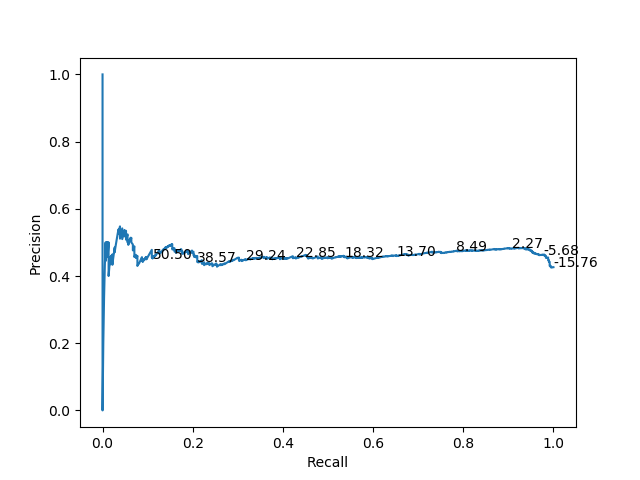

In [163]:
# Example: precision-recall curve (with annotated thresholds)
nextplot()
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(ytest, yhat)
plt.plot(recall, precision)
for x in np.linspace(0,1,10,endpoint=False):
    index = int(x * (precision.size-1))
    plt.text(recall[index], precision[index], "{:3.2f}".format(thresholds[index]))
plt.xlabel("Recall")
plt.ylabel("Precision")

# 4 Maximum Aposteriori Estimation

## 4a Gradient Descent

In [ ]:
def l_l2(y,X,w,lambda_):
    """Log-density of posterior of logistic regression with weights w and L2
regularization parameter lambda_"""
    # YOUR CODE HERE

In [ ]:
# this should give:
# [-47066.641667825766, -47312.623810682911]
[ l_l2(y, Xz, np.linspace(-5,5,D),0), l_l2(y, Xz, np.linspace(-5,5,D),1) ]

In [ ]:
def dl_l2(y,X,w,lambda_):
    """Gradient of log-density of posterior of logistic regression with weights w
and L2 regularization parameter lambda_."""
    # YOUR CODE HERE

In [ ]:
# this should give:
# [array([  551.33985842,   143.84116318,   841.83373606,   156.87237578,
#           802.61217579,   795.96202907,   920.69045803,   621.96516752,
#           659.18724769,   470.81259805,   771.32406968,   352.40325626,
#           455.66972482,   234.36600888,   562.45454038,   864.83981264,
#           787.19723703,   649.48042176,   902.6478154 ,   544.00539886,
#          1174.78638035,   120.3598967 ,   839.61141672,   633.30453444,
#          -706.66815087,  -630.2039816 ,  -569.3451386 ,  -527.50996698,
#          -359.53701083,  -476.64334832,  -411.60620464,  -375.11950586,
#          -345.37195689,  -376.22044258,  -407.31761977,  -456.23251936,
#          -596.86960184,  -107.97072355,  -394.82170044,  -229.18125598,
#          -288.46356547,  -362.13402385,  -450.87896465,  -277.03932676,
#          -414.99293368,  -452.28771693,  -167.54649092,  -270.9043748 ,
#          -252.20140951,  -357.72497343,  -259.12468742,   418.35938483,
#           604.54173228,    43.10390907,   152.24258478,   378.16731033,
#           416.12032881]),
#  array([  556.33985842,   148.66259175,   846.4765932 ,   161.33666149,
#           806.89789007,   800.06917193,   924.61902946,   625.71516752,
#           662.75867626,   474.20545519,   774.5383554 ,   355.43897054,
#           458.52686767,   237.04458031,   564.95454038,   867.16124121,
#           789.34009417,   651.44470748,   904.43352968,   545.61254171,
#          1176.21495178,   121.6098967 ,   840.68284529,   634.19739158,
#          -705.95386516,  -629.66826731,  -568.98799574,  -527.33139555,
#          -359.53701083,  -476.82191975,  -411.9633475 ,  -375.65522015,
#          -346.08624261,  -377.11329972,  -408.38904835,  -457.48251936,
#          -598.29817327,  -109.57786641,  -396.60741472,  -231.14554169,
#          -290.60642261,  -364.45545242,  -453.37896465,  -279.71789819,
#          -417.85007654,  -455.32343122,  -170.76077664,  -274.29723194,
#          -255.77283808,  -361.47497343,  -263.05325885,   414.25224198,
#           600.25601799,    38.63962335,   147.59972763,   373.34588176,
#           411.12032881])]
[ dl_l2(y, Xz, np.linspace(-5,5,D),0), dl_l2(y, Xz, np.linspace(-5,5,D),1) ]

In [ ]:
# now define the (f,update) tuple for optimize for logistic regression, L2
# regularization, and gradient descent
def gd_l2(y,X,lambda_):
    # YOUR CODE HERE

In [ ]:
# let's run!
lambda_ = 100
wz_gd_l2, vz_gd_l2, ez_gd_l2 = optimize(gd_l2(y,Xz,lambda_), w0, nepochs=500)

## 4b Effect of Prior

In [ ]:
# YOUR CODE HERE

## 4c Composition of Weight Vector

In [ ]:
# YOUR CODE HERE

## 5 Exploration (optional)

In [ ]:
# all yours